# Figure 9: Decoupling flicker and motion

In [1]:
from setup_nb import *
from numba import jit

In [2]:
from detector.implementations import TwoQ, FourQ
from detector.stimulus import fast_discrete_phi

### Behavioral data

In [3]:
data_ = pd.read_hdf("../data/decoupled.data", "data")

# These data were preprocessed/stored at 100Hz, but the manifest has 20Hz -- so everything's off by a linear factor of 5
data = preprocess_standard(data_, filter=None) * 5.0

evald = groupexcept(data, 'time').aggregate(rangemean, r=slice(1.5, 3.0))
mat_data = evald.rotation.groupby(["jump_f", "switch_f"]).mean().unstack().values
mat_data = mat_data / np.abs(mat_data.flatten()).max()

### Simulations

#### Parameters

In [4]:
dt = 0.001

### Stimulus

base_args = {
    "duration": 10.0,
    "start": 0.5,
    "stop": 9.5,
    "lam": 90.0,
    "jump_width": 4.0,
    "phase_motion": 1.0,
    "phase_flicker": 1.0,
    "recfield": 240.0,
    "delta_phi": 4.0,
    "dt": dt,
}

contrast = 0.25
offset = 1.3

fs_motion = np.array([0.0, 8.0, 16.0, 32.0, 64.0])
fs_flicker = np.array([0.0, 8.0, 16.0, 32.0, 64.0])

### Detectors

tau_hp = 0.25
tau_lp = 0.05

d_2q_dc = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=dt)
d_4q = FourQ(tau_hp=tau_hp, tau_lp=tau_lp, dc=0.0, dt=dt)

#### Run

In [5]:
def run(detector):
        
    sys.stdout.write("\n"); sys.stdout.flush()
    
    c = np.zeros((len(fs_motion), len(fs_flicker)))
    
    for m_idx, f_motion in enumerate(fs_motion):
        for f_idx, f_flicker in enumerate(fs_flicker):
                        
            stim = fast_discrete_phi(f_motion=f_motion, f_flicker=f_flicker, **base_args)
            stim = np.maximum(contrast * stim + offset, 0)
        
            output = detector.detect(stim)
            c[m_idx, f_idx] = output.mean()
            sys.stdout.write("."); sys.stdout.flush()
        
    return c / np.abs(c.flatten()).max()

In [6]:
mat_2q = run(d_2q_dc)
mat_4q = run(d_4q)


.........................
.........................

### Panels

In [7]:
def plot_matrix(mat, ax, clip=1.0, saturate=False, cax=None):
    
    if saturate:
        mat = np.tanh(2.2 * mat)

    pc = ax.pcolormesh(mat.T, cmap="PRGn", vmin=-clip, vmax=clip, linewidth=0, rasterized=True)

    ax.set_xticklabels(fs_motion.astype(np.int))
    ax.set_xticks(np.arange(len(fs_motion)) + 0.5)

    ax.set_yticklabels(fs_flicker.astype(np.int))
    ax.set_yticks(np.arange(len(fs_flicker)) + 0.5)

    ax.invert_yaxis()
    ax.set_xlabel("Step frequency (Hz)")
    ax.set_ylabel("Flicker\nfrequency (Hz)")
    
    if cax:
        cb = sb.plt.colorbar(pc, cax=cax)
        cb.set_label("Normalized\nresponse (a.u.)", labelpad=-9)
        cb.set_ticks([-clip, 0, clip])
        cb.set_ticklabels(["< {0}".format(-clip), "0", "> {0}".format(clip)])
        cax.tick_params(axis='both', which='major', pad=2)

    sb.despine(ax=ax)

In [25]:
def plot_behavior(ax):
    
    sb.pointplot(data=evald.reset_index(), x="jump_f", y="rotation", hue="switch_f",
                 ci=standard_ci, ax=ax, palette=sb.color_palette("GnBu_d"))
    
    ax.legend_.remove()
    ax.legend(loc=(1.1, 0.0))
    ax.legend_.set_title("$\mathregular{f_{Flicker}}$ (Hz)", prop={'size': 7})
    for t in ax.legend_.get_texts():
        t.set_text("{0}".format(int(float(t.get_text()))))
    ax.set_xticklabels(fs_motion.astype(np.int))
    
    ax.set_ylim([-50, 175])
    ax.set_yticks([-50, 0, 50, 100, 150])
    
    for handle in ax.legend_.legendHandles:
        handle.set_sizes([20.0])
    
    ax.set_xlabel("Step frequency (Hz)")
    ax.set_ylabel(u"Turning speed (°/s)")
    
    add_refline(ax, horizontal=True)
    sb.despine(ax=ax)

In [20]:
def plot_diag(ax):
    
    x = np.arange(mat_data.shape[0])
    
    ax.plot(x, mat_data.diagonal(), label="Behavior", color="black")
    ax.plot(x, mat_4q.diagonal(), label="4Q", color="gray")
    ax.plot(x, mat_2q.diagonal(), label="2Q", color="red")
    
    ax.set_xticks(x)
    ax.set_xticklabels(fs_motion.astype(np.uint))
    
    ax.set_ylim([-0.5, 0.3])
    ax.set_yticks([-0.4, -0.2, 0, 0.2])
    
    ax.set_xlabel("Update frequency (Hz)")
    ax.set_ylabel("Normalized\nresponse (a.u.)")
    
    ax.legend(loc=(0.4, 0.9))
    
    add_refline(ax, horizontal=True)
    
    sb.despine(ax=ax)

In [27]:
def flicker_figure():
        
    saturate = False
    clip = 0.5
    
    panelsize = (2, 2)

    fig = sb.plt.figure(figsize=(4.4, 3))

    height = 5
    
    ax = addaxis(fig, (1.8, height), panelsize, letter="a", nudge=0.4)
    plot_behavior(ax)
    
    ax = addaxis(fig, (6.9, height), panelsize, letter="b", nudge=0.6)
    cax = addaxis(fig, (9.2, height), (0.15, 2), letter="")
    plot_matrix(mat_data, ax, saturate=saturate, clip=clip, cax=cax)
    ax.set_title("Behavior")
    
    height = 1.3
    
    ax = addaxis(fig, (1.8, height), panelsize, letter="c", nudge=0.4)
    plot_matrix(mat_4q, ax, saturate=saturate, clip=clip)
    ax.set_title("4Q")
    
    ax = addaxis(fig, (4.4, height), panelsize, letter="d")
    plot_matrix(mat_2q, ax, saturate=saturate, clip=clip)
    remove_axis(ax, y=True)
    ax.set_title("2Q")
    
    ax = addaxis(fig, (8.2, height), panelsize, letter="e", nudge=0.6)
    plot_diag(ax)
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig9.tif", format="tiff", dpi=standard_dpi)

### Plot

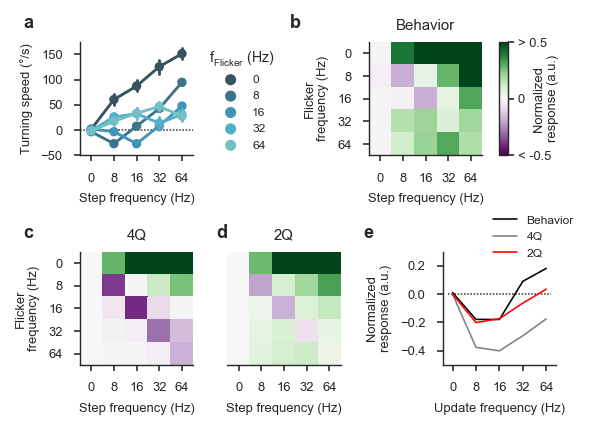

In [26]:
flicker_figure()